# Experiment on imputation methods

**How to deal with null/emtpy values**

## Table of contents

- [0. Introduction](#bullet-0)

- [1. Imputation of x features](#bullet-1)

- [2. Imputation results](#bullet-2)

- [3. Model predictions results](#bullet-3)

- [4. Conclusions](#bullet-4)


## 0. Introduction <a class="anchor" id="bullet-0"></a>

As we learn how to make our Data Science projects as scientific and accurate as possible, different methods and procedures are to be learnt. Quite often, several methods exist to solve the same issue. One of these situations is dealing with null/empty values.

An interesting article on different ways of dealing with null values can be found [here](https://towardsdatascience.com/imputing-missing-data-with-simple-and-advanced-techniques-f5c7b157fb87). However, the article demonstrates how to apply the different methods, but doesn't compare their effectiveness. This leads us to the goal of this project.

#### Project goal

<ins>The goal of this experiment is to compare the accurateness of different imputation methods</ins>. We'll do so by using a dataset created using [Google Sheets](https://docs.google.com/spreadsheets/) where we have related x features and a target variable y. Besides that original dataset, we'll use two additional datasets that resemble the original dataset, but with 20% or 80% empty values. Let's check how the data was created with more detail:

### 0.a) Data creation

#### Original dataset

The dataset "Imputations_experiment - Complete" contains 1000 rows with 0 null/empty values. We'll use row number 2 (row number 1 contains headers) to illustrate the formulas here:

- column A: **x1_rand_0_1000** = RANDBETWEEN(0;1000)

- column B: **cat_x1_250** = IF(A2<250;1;0)

- column C: **x2_3x1_20perc** = 3*A2+RANDBETWEEN(-0,2*A2;0,2*A2)

- column D: **cat_x2_700** = IF(C2<700;1;0)

- column E: **x3_4xsquared_50perc** = 4*A2^2+RANDBETWEEN(-0,5*A2;0,5*A2)

- column F: **cat_x3_500000** = IF(E2<500000;1;0)

- column G: **y** = 0,3*A2^3-0,2*C2^2+0,1*E2

#### Modified datasets with missing values

The datasets "Imputations_experiment - Null_20perc" and "Imputations_experiment - Null_80perc" basically refer to
"Imputations_experiment - Complete" except for some rows that will have empty values. Let us examine the row number 2
from "Imputations_experiment - Null_20perc" as an example:

column A: **x1_rand_0_1000** = Complete!A2

column B: **cat_x1_250** = IF($H2=0;Complete!B2;"")

column C: **x2_3x1_20perc** = IF($H2=0;Complete!C2;"")

column D: **cat_x2_700** = IF($H2=0;Complete!D2;"")

column E: **x3_4xsquared_50perc** = IF($H2=0;Complete!E2;"")

column F: **cat_x3_500000** = IF($H2=0;Complete!F2;"")

column G: **y** = IF($H2=0;Complete!G2;"")

column H: **null_20perc** = =IF(RAND()<0,2;1;0)


The dataset "Imputations_experiment - Null_80perc" is exactly the same, but the column H changes to:

column H: **null_20perc** = =IF(RAND()<0,8;1;0)


### 0.b) Set the environment and load the data

In [1]:
# Import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from impyute.imputation.cs import mice
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Remove scientific notation by setting floats to 1 decimal point
pd.options.display.float_format = '{:.1f}'.format

# Load the dataframes
all_x_y_com = pd.read_csv("Imputations_experiment - Complete.csv", decimal=",")
all_x_y_del20 = pd.read_csv("Imputations_experiment - Null_20perc.csv", decimal=",")
all_x_y_del80 = pd.read_csv("Imputations_experiment - Null_80perc.csv", decimal=",")

# Separate into x features to test imputation and y features to test model predictions
df_com = all_x_y_com.iloc[:, :-1]
df_del20 = all_x_y_del20.iloc[:, :-2]
df_del80 = all_x_y_del80.iloc[:, :-2]

y_com = all_x_y_com["y"]
y_del20 = all_x_y_del20["y"]
y_del80 = all_x_y_del80["y"]

# Create a mask with the null values index
null_mask20 = df_del20.isna().any(axis=1)
null_mask80 = df_del80.isna().any(axis=1)

# Display info about dataframes
print("\nDataframe with complete data head and sum of nulls:")
display(df_com.head(), df_com.isna().sum())

print("\nDataframe with missing data (20% nulls) head and sum of nulls:")
display(df_del20.head(), df_del20.isna().sum())

print("\nRows with missing data (20% nulls):")
display(df_del20[null_mask20].head())

print("\nDataframe with missing data (80% nulls) head and sum of nulls:")
display(df_del80.head(), df_del80.isna().sum())

print("\nRows with missing data (20% nulls):")
display(df_del80[null_mask20].head())


Dataframe with complete data head and sum of nulls:


,x1_rand_0_1000,cat_x1_250,x2_3x1_20perc,cat_x2_700,x3_4xsquared_50perc,cat_x3_500000
0,636,0,1786,0,1617977,0
1,514,0,1449,0,1056853,0
2,809,0,2271,0,2617790,0
3,128,1,360,1,65554,1
4,583,0,1800,0,1359720,0


x1_rand_0_1000         0
cat_x1_250             0
x2_3x1_20perc          0
cat_x2_700             0
x3_4xsquared_50perc    0
cat_x3_500000          0
dtype: int64


Dataframe with missing data (20% nulls) head and sum of nulls:


,x1_rand_0_1000,cat_x1_250,x2_3x1_20perc,cat_x2_700,x3_4xsquared_50perc,cat_x3_500000
0,636,0.0,1786.0,0.0,1617977.0,0.0
1,514,0.0,1449.0,0.0,1056853.0,0.0
2,809,0.0,2271.0,0.0,2617790.0,0.0
3,128,1.0,360.0,1.0,65554.0,1.0
4,583,0.0,1800.0,0.0,1359720.0,0.0


x1_rand_0_1000           0
cat_x1_250             205
x2_3x1_20perc          205
cat_x2_700             205
x3_4xsquared_50perc    205
cat_x3_500000          205
dtype: int64


Rows with missing data (20% nulls):


,x1_rand_0_1000,cat_x1_250,x2_3x1_20perc,cat_x2_700,x3_4xsquared_50perc,cat_x3_500000
9,275,NaN,NaN,NaN,NaN,NaN
16,346,NaN,NaN,NaN,NaN,NaN
22,1000,NaN,NaN,NaN,NaN,NaN
31,914,NaN,NaN,NaN,NaN,NaN
33,856,NaN,NaN,NaN,NaN,NaN



Dataframe with missing data (80% nulls) head and sum of nulls:


,x1_rand_0_1000,cat_x1_250,x2_3x1_20perc,cat_x2_700,x3_4xsquared_50perc,cat_x3_500000
0,636,NaN,NaN,NaN,NaN,NaN
1,514,NaN,NaN,NaN,NaN,NaN
2,809,NaN,NaN,NaN,NaN,NaN
3,128,NaN,NaN,NaN,NaN,NaN
4,583,NaN,NaN,NaN,NaN,NaN


x1_rand_0_1000           0
cat_x1_250             797
x2_3x1_20perc          797
cat_x2_700             797
x3_4xsquared_50perc    797
cat_x3_500000          797
dtype: int64


Rows with missing data (20% nulls):


,x1_rand_0_1000,cat_x1_250,x2_3x1_20perc,cat_x2_700,x3_4xsquared_50perc,cat_x3_500000
9,275,NaN,NaN,NaN,NaN,NaN
16,346,0.0,1054.0,0.0,478941.0,1.0
22,1000,NaN,NaN,NaN,NaN,NaN
31,914,NaN,NaN,NaN,NaN,NaN
33,856,0.0,2684.0,0.0,2931217.0,0.0


## 1. Imputation of x features <a class="anchor" id="bullet-1"></a>

On the following code cell, we'll get new dataframes by using mean, [MICE](https://impyute.readthedocs.io/en/master/_modules/impyute/imputation/cs/mice.html) and
[KNN](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html) imputation methods. Also, we'll calculate how accurate their imputed values are.

In [2]:
# Initiate empty dictionary to store dataframes with imputed values and accuracy of imputation methods
imputed_dfs = {}
accuracy = {}

# Iterate over the different imputation methods
for method in ["mean", "MICE", "KNN"]:
    
    # Iterate over both nulls percentages
    for nulls_perc in ["20", "80"]:
        
        # Choose proper dataframe to start imputation        
        if nulls_perc == "20":
            impute_df = df_del20.copy()
        
        elif nulls_perc == "80":
            impute_df = df_del80.copy()
    
        # Impute values following imputation method
        if method == "mean":            
            for column in impute_df.columns:
                impute_df[column].fillna(impute_df[column].mean(), inplace=True)
       
        elif method == "MICE":
            impute_df = pd.DataFrame(mice(impute_df.values), columns=impute_df.columns)
        
        elif method == "KNN":
            imputer = KNNImputer()
            impute_df = pd.DataFrame(imputer.fit_transform(impute_df), columns=impute_df.columns)
            
        # Store dataframe with imputed values in dictionary
        imputed_dfs[method + nulls_perc] = impute_df
        
        # Generate another imputed dataframe where numbers between 0 and 1 (categorical features) are rounded
        rounded_data = np.where((impute_df > .5) & (impute_df < 1), 1,
                                  np.where((impute_df > .0) & (impute_df < .5), 0, impute_df))
        rounded_df = pd.DataFrame(rounded_data, columns = impute_df.columns)
        
        # Display original and imputed data for comparison purposes
        print("\n\n\nResults from " + method + " imputation method (" + nulls_perc + "% null values):" + "\n---------------------------------------------------------" )
        
        print("\nNull rows from dataframe with original values:")
        display(df_com[null_mask20].head())
        
        print("\nNull rows from dataframe with raw imputed values (" + method + "):")
        display(impute_df[null_mask20].head())

        print("\nNull rows from dataframe with rounded imputed values (" + method + "):")
        display(rounded_df[null_mask20].head())        

        # Calculate accuracy of imputation across the different features
        
        acc_cat_x1_raw = np.sqrt(mean_squared_error(impute_df.loc[null_mask20, "cat_x1_250"], df_com.loc[null_mask20, "cat_x1_250"]))
        acc_cat_x1_round = np.mean(rounded_df.loc[null_mask20, "cat_x1_250"] == df_com.loc[null_mask20, "cat_x1_250"])
        acc_num_x2 = np.sqrt(mean_squared_error(impute_df.loc[null_mask20, "x2_3x1_20perc"], df_com.loc[null_mask20, "x2_3x1_20perc"]))
        acc_cat_x2_raw = np.sqrt(mean_squared_error(impute_df.loc[null_mask20, "cat_x2_700"], df_com.loc[null_mask20, "cat_x2_700"]))
        acc_cat_x2_round = np.mean(rounded_df.loc[null_mask20, "cat_x2_700"] == df_com.loc[null_mask20, "cat_x2_700"])
        acc_num_x3 = np.sqrt(mean_squared_error(impute_df.loc[null_mask20, "x3_4xsquared_50perc"], df_com.loc[null_mask20, "x3_4xsquared_50perc"]))
        acc_cat_x3_raw = np.sqrt(mean_squared_error(impute_df.loc[null_mask20, "cat_x3_500000"], df_com.loc[null_mask20, "cat_x3_500000"]))
        acc_cat_x3_round = np.mean(rounded_df.loc[null_mask20, "cat_x3_500000"] == df_com.loc[null_mask20, "cat_x3_500000"])

        # Append results to dictionary
        accuracy["Cat_raw_x1_" + method + "_" + nulls_perc] = acc_cat_x1_raw
        accuracy["Cat_round_x1_" + method + "_" + nulls_perc] = acc_cat_x1_round
        accuracy["Num_x2_" + method + "_" + nulls_perc] = acc_num_x2
        accuracy["Cat_raw_x2_" + method + "_" + nulls_perc] = acc_cat_x2_raw
        accuracy["Cat_round_x2_" + method + "_" + nulls_perc] = acc_cat_x2_round
        accuracy["Num_x3_" + method + "_" + nulls_perc] = acc_num_x3
        accuracy["Cat_raw_x3_" + method + "_" + nulls_perc] = acc_cat_x3_raw
        accuracy["Cat_round_x3_" + method + "_" + nulls_perc] = acc_cat_x3_round

        # Display results from the analysis
        print("\nRMSE for categorical feature x1 missing 20% (" + method + "):", round(acc_cat_x1_raw, 4))
        print("\n% of correct predictions for rounded categorical feature x1 missing 20% (" + method + "):", round(acc_cat_x1_round, 4))
        print("\nRMSE for numerical feature x2 missing 20% (" + method + "):", round(acc_num_x2, 4))
        print("\nRMSE for categorical feature x2 missing 20% (" + method + "):", round(acc_cat_x2_raw, 4))
        print("\n% of correct predictions for rounded categorical feature x2 missing 20% (" + method + "):", round(acc_cat_x2_round, 4))
        print("\nRMSE for numerical feature x3 missing 20% (" + method + "):", round(acc_num_x3, 4))
        print("\nRMSE for categorical feature x3 missing 20% (" + method + "):", round(acc_cat_x3_raw, 4))
        print("\n% of correct predictions for rounded categorical feature x3 missing 20% (" + method + "):", round(acc_cat_x3_round, 4))




Results from mean imputation method (20% null values):
---------------------------------------------------------

Null rows from dataframe with original values:


,x1_rand_0_1000,cat_x1_250,x2_3x1_20perc,cat_x2_700,x3_4xsquared_50perc,cat_x3_500000
9,275,0,869,0,302594,1
16,346,0,1054,0,478941,1
22,1000,0,2927,0,3999857,0
31,914,0,2817,0,3341305,0
33,856,0,2684,0,2931217,0



Null rows from dataframe with raw imputed values (mean):


,x1_rand_0_1000,cat_x1_250,x2_3x1_20perc,cat_x2_700,x3_4xsquared_50perc,cat_x3_500000
9,275,0.3,1461.8,0.3,1281030.9,0.4
16,346,0.3,1461.8,0.3,1281030.9,0.4
22,1000,0.3,1461.8,0.3,1281030.9,0.4
31,914,0.3,1461.8,0.3,1281030.9,0.4
33,856,0.3,1461.8,0.3,1281030.9,0.4



Null rows from dataframe with rounded imputed values (mean):


,x1_rand_0_1000,cat_x1_250,x2_3x1_20perc,cat_x2_700,x3_4xsquared_50perc,cat_x3_500000
9,275.0,0.0,1461.8,0.0,1281030.9,0.0
16,346.0,0.0,1461.8,0.0,1281030.9,0.0
22,1000.0,0.0,1461.8,0.0,1281030.9,0.0
31,914.0,0.0,1461.8,0.0,1281030.9,0.0
33,856.0,0.0,1461.8,0.0,1281030.9,0.0



RMSE for categorical feature x1 missing 20% (mean): 0.4194

% of correct predictions for rounded categorical feature x1 missing 20% (mean): 0.7756

RMSE for numerical feature x2 missing 20% (mean): 857.1914

RMSE for categorical feature x2 missing 20% (mean): 0.4152

% of correct predictions for rounded categorical feature x2 missing 20% (mean): 0.7805

RMSE for numerical feature x3 missing 20% (mean): 1179873.9779

RMSE for categorical feature x3 missing 20% (mean): 0.4695

% of correct predictions for rounded categorical feature x3 missing 20% (mean): 0.678



Results from mean imputation method (80% null values):
---------------------------------------------------------

Null rows from dataframe with original values:


,x1_rand_0_1000,cat_x1_250,x2_3x1_20perc,cat_x2_700,x3_4xsquared_50perc,cat_x3_500000
9,275,0,869,0,302594,1
16,346,0,1054,0,478941,1
22,1000,0,2927,0,3999857,0
31,914,0,2817,0,3341305,0
33,856,0,2684,0,2931217,0



Null rows from dataframe with raw imputed values (mean):


,x1_rand_0_1000,cat_x1_250,x2_3x1_20perc,cat_x2_700,x3_4xsquared_50perc,cat_x3_500000
9,275,0.2,1586.6,0.2,1428576.6,0.3
16,346,0.0,1054.0,0.0,478941.0,1.0
22,1000,0.2,1586.6,0.2,1428576.6,0.3
31,914,0.2,1586.6,0.2,1428576.6,0.3
33,856,0.0,2684.0,0.0,2931217.0,0.0



Null rows from dataframe with rounded imputed values (mean):


,x1_rand_0_1000,cat_x1_250,x2_3x1_20perc,cat_x2_700,x3_4xsquared_50perc,cat_x3_500000
9,275.0,0.0,1586.6,0.0,1428576.6,0.0
16,346.0,0.0,1054.0,0.0,478941.0,1.0
22,1000.0,0.0,1586.6,0.0,1428576.6,0.0
31,914.0,0.0,1586.6,0.0,1428576.6,0.0
33,856.0,0.0,2684.0,0.0,2931217.0,0.0



RMSE for categorical feature x1 missing 20% (mean): 0.3822

% of correct predictions for rounded categorical feature x1 missing 20% (mean): 0.8098

RMSE for numerical feature x2 missing 20% (mean): 762.3323

RMSE for categorical feature x2 missing 20% (mean): 0.3787

% of correct predictions for rounded categorical feature x2 missing 20% (mean): 0.8146

RMSE for numerical feature x3 missing 20% (mean): 1056917.2072

RMSE for categorical feature x3 missing 20% (mean): 0.4163

% of correct predictions for rounded categorical feature x3 missing 20% (mean): 0.7512



Results from MICE imputation method (20% null values):
---------------------------------------------------------

Null rows from dataframe with original values:


,x1_rand_0_1000,cat_x1_250,x2_3x1_20perc,cat_x2_700,x3_4xsquared_50perc,cat_x3_500000
9,275,0,869,0,302594,1
16,346,0,1054,0,478941,1
22,1000,0,2927,0,3999857,0
31,914,0,2817,0,3341305,0
33,856,0,2684,0,2931217,0



Null rows from dataframe with raw imputed values (MICE):


,x1_rand_0_1000,cat_x1_250,x2_3x1_20perc,cat_x2_700,x3_4xsquared_50perc,cat_x3_500000
9,275.0,0.5,825.8,0.5,430843.5,0.7
16,346.0,0.4,1039.0,0.4,715816.2,0.6
22,1000.0,-0.3,3002.8,-0.3,3340775.8,-0.3
31,914.0,-0.2,2744.6,-0.2,2995597.6,-0.2
33,856.0,-0.2,2570.4,-0.1,2762803.0,-0.1



Null rows from dataframe with rounded imputed values (MICE):


,x1_rand_0_1000,cat_x1_250,x2_3x1_20perc,cat_x2_700,x3_4xsquared_50perc,cat_x3_500000
9,275.0,1.0,825.8,0.0,430843.5,1.0
16,346.0,0.0,1039.0,0.0,715816.2,1.0
22,1000.0,-0.3,3002.8,-0.3,3340775.8,-0.3
31,914.0,-0.2,2744.6,-0.2,2995597.6,-0.2
33,856.0,-0.2,2570.4,-0.1,2762803.0,-0.1



RMSE for categorical feature x1 missing 20% (MICE): 0.2821

% of correct predictions for rounded categorical feature x1 missing 20% (MICE): 0.6244

RMSE for numerical feature x2 missing 20% (MICE): 61.5353

RMSE for categorical feature x2 missing 20% (MICE): 0.2823

% of correct predictions for rounded categorical feature x2 missing 20% (MICE): 0.6537

RMSE for numerical feature x3 missing 20% (MICE): 281110.1945

RMSE for categorical feature x3 missing 20% (MICE): 0.2661

% of correct predictions for rounded categorical feature x3 missing 20% (MICE): 0.6732



Results from MICE imputation method (80% null values):
---------------------------------------------------------

Null rows from dataframe with original values:


,x1_rand_0_1000,cat_x1_250,x2_3x1_20perc,cat_x2_700,x3_4xsquared_50perc,cat_x3_500000
9,275,0,869,0,302594,1
16,346,0,1054,0,478941,1
22,1000,0,2927,0,3999857,0
31,914,0,2817,0,3341305,0
33,856,0,2684,0,2931217,0



Null rows from dataframe with raw imputed values (MICE):


,x1_rand_0_1000,cat_x1_250,x2_3x1_20perc,cat_x2_700,x3_4xsquared_50perc,cat_x3_500000
9,275.0,0.4,828.6,0.4,336124.8,0.6
16,346.0,0.0,1054.0,0.0,478941.0,1.0
22,1000.0,-0.1,3020.5,-0.1,3495333.1,-0.3
31,914.0,-0.1,2760.5,-0.1,3120585.7,-0.2
33,856.0,0.0,2684.0,0.0,2931217.0,0.0



Null rows from dataframe with rounded imputed values (MICE):


,x1_rand_0_1000,cat_x1_250,x2_3x1_20perc,cat_x2_700,x3_4xsquared_50perc,cat_x3_500000
9,275.0,0.0,828.6,0.0,336124.8,1.0
16,346.0,0.0,1054.0,0.0,478941.0,1.0
22,1000.0,-0.1,3020.5,-0.1,3495333.1,-0.3
31,914.0,-0.1,2760.5,-0.1,3120585.7,-0.2
33,856.0,0.0,2684.0,0.0,2931217.0,0.0



RMSE for categorical feature x1 missing 20% (MICE): 0.2748

% of correct predictions for rounded categorical feature x1 missing 20% (MICE): 0.7512

RMSE for numerical feature x2 missing 20% (MICE): 55.4407

RMSE for categorical feature x2 missing 20% (MICE): 0.2744

% of correct predictions for rounded categorical feature x2 missing 20% (MICE): 0.7561

RMSE for numerical feature x3 missing 20% (MICE): 269775.823

RMSE for categorical feature x3 missing 20% (MICE): 0.2486

% of correct predictions for rounded categorical feature x3 missing 20% (MICE): 0.7951



Results from KNN imputation method (20% null values):
---------------------------------------------------------

Null rows from dataframe with original values:


,x1_rand_0_1000,cat_x1_250,x2_3x1_20perc,cat_x2_700,x3_4xsquared_50perc,cat_x3_500000
9,275,0,869,0,302594,1
16,346,0,1054,0,478941,1
22,1000,0,2927,0,3999857,0
31,914,0,2817,0,3341305,0
33,856,0,2684,0,2931217,0



Null rows from dataframe with raw imputed values (KNN):


,x1_rand_0_1000,cat_x1_250,x2_3x1_20perc,cat_x2_700,x3_4xsquared_50perc,cat_x3_500000
9,275.0,0.0,814.0,0.0,304308.6,1.0
16,346.0,0.0,1025.2,0.0,477716.6,1.0
22,1000.0,0.0,2996.4,0.0,3981020.2,0.0
31,914.0,0.0,2843.6,0.0,3341674.4,0.0
33,856.0,0.0,2570.0,0.0,2937884.8,0.0



Null rows from dataframe with rounded imputed values (KNN):


,x1_rand_0_1000,cat_x1_250,x2_3x1_20perc,cat_x2_700,x3_4xsquared_50perc,cat_x3_500000
9,275.0,0.0,814.0,0.0,304308.6,1.0
16,346.0,0.0,1025.2,0.0,477716.6,1.0
22,1000.0,0.0,2996.4,0.0,3981020.2,0.0
31,914.0,0.0,2843.6,0.0,3341674.4,0.0
33,856.0,0.0,2570.0,0.0,2937884.8,0.0



RMSE for categorical feature x1 missing 20% (KNN): 0.014

% of correct predictions for rounded categorical feature x1 missing 20% (KNN): 1.0

RMSE for numerical feature x2 missing 20% (KNN): 70.2149

RMSE for categorical feature x2 missing 20% (KNN): 0.0815

% of correct predictions for rounded categorical feature x2 missing 20% (KNN): 0.9854

RMSE for numerical feature x3 missing 20% (KNN): 5642.4884

RMSE for categorical feature x3 missing 20% (KNN): 0.0242

% of correct predictions for rounded categorical feature x3 missing 20% (KNN): 1.0



Results from KNN imputation method (80% null values):
---------------------------------------------------------

Null rows from dataframe with original values:


,x1_rand_0_1000,cat_x1_250,x2_3x1_20perc,cat_x2_700,x3_4xsquared_50perc,cat_x3_500000
9,275,0,869,0,302594,1
16,346,0,1054,0,478941,1
22,1000,0,2927,0,3999857,0
31,914,0,2817,0,3341305,0
33,856,0,2684,0,2931217,0



Null rows from dataframe with raw imputed values (KNN):


,x1_rand_0_1000,cat_x1_250,x2_3x1_20perc,cat_x2_700,x3_4xsquared_50perc,cat_x3_500000
9,275.0,0.0,831.4,0.0,300857.0,1.0
16,346.0,0.0,1054.0,0.0,478941.0,1.0
22,1000.0,0.0,2992.2,0.0,3925217.6,0.0
31,914.0,0.0,2808.8,0.0,3344812.4,0.0
33,856.0,0.0,2684.0,0.0,2931217.0,0.0



Null rows from dataframe with rounded imputed values (KNN):


,x1_rand_0_1000,cat_x1_250,x2_3x1_20perc,cat_x2_700,x3_4xsquared_50perc,cat_x3_500000
9,275.0,0.0,831.4,0.0,300857.0,1.0
16,346.0,0.0,1054.0,0.0,478941.0,1.0
22,1000.0,0.0,2992.2,0.0,3925217.6,0.0
31,914.0,0.0,2808.8,0.0,3344812.4,0.0
33,856.0,0.0,2684.0,0.0,2931217.0,0.0



RMSE for categorical feature x1 missing 20% (KNN): 0.0242

% of correct predictions for rounded categorical feature x1 missing 20% (KNN): 1.0

RMSE for numerical feature x2 missing 20% (KNN): 64.3999

RMSE for categorical feature x2 missing 20% (KNN): 0.0726

% of correct predictions for rounded categorical feature x2 missing 20% (KNN): 0.9951

RMSE for numerical feature x3 missing 20% (KNN): 15176.5082

RMSE for categorical feature x3 missing 20% (KNN): 0.0504

% of correct predictions for rounded categorical feature x3 missing 20% (KNN): 0.9951


## 2. Imputation results <a class="anchor" id="bullet-2"></a>

On the following code cell, we'll plot the results obtained above, to facilitate results' comparison.



Results from dataset with 20% null values:
-----------------------------------------------


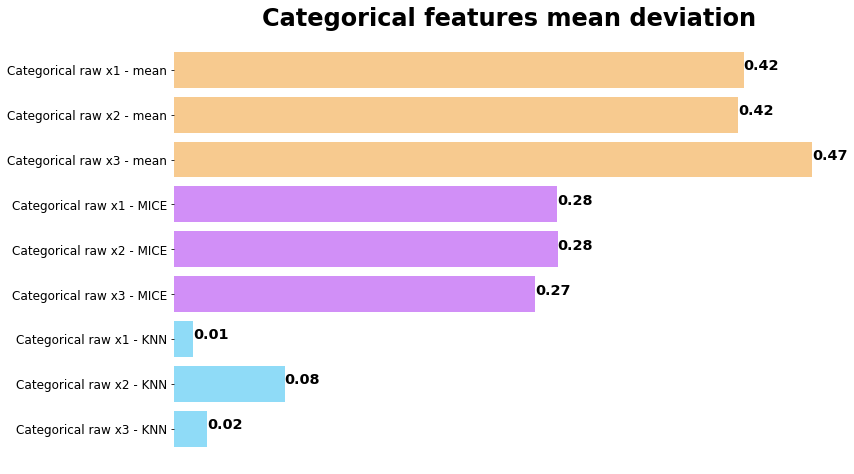

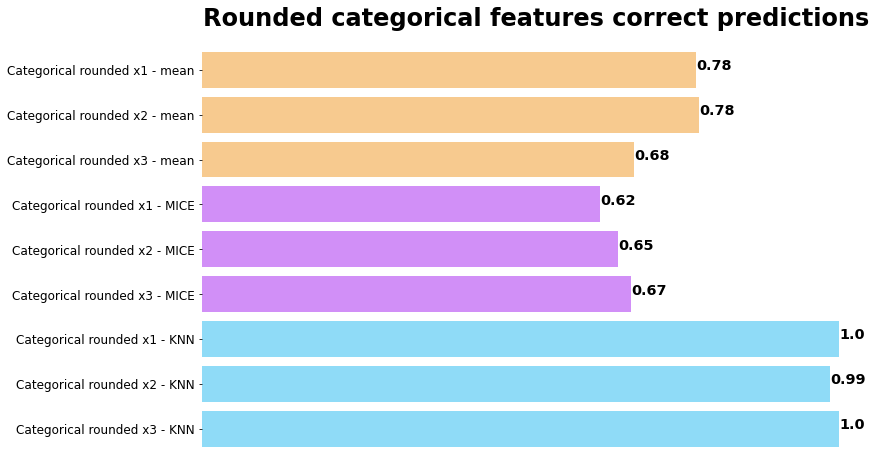

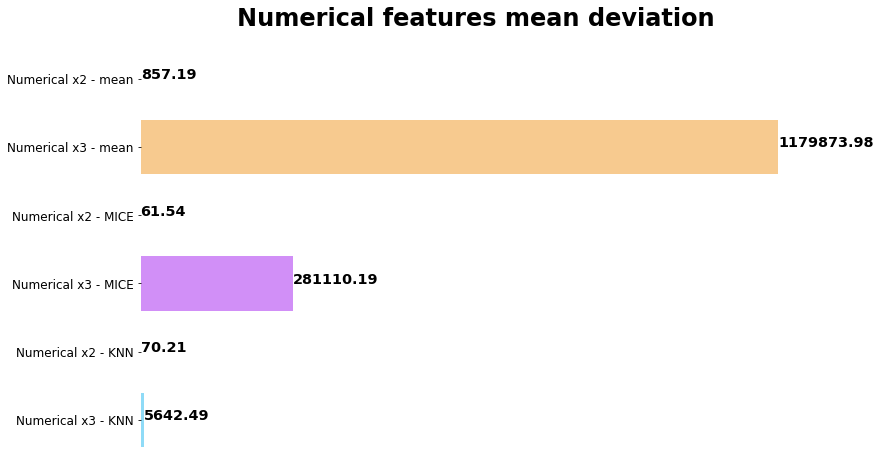



Results from dataset with 80% null values:
-----------------------------------------------


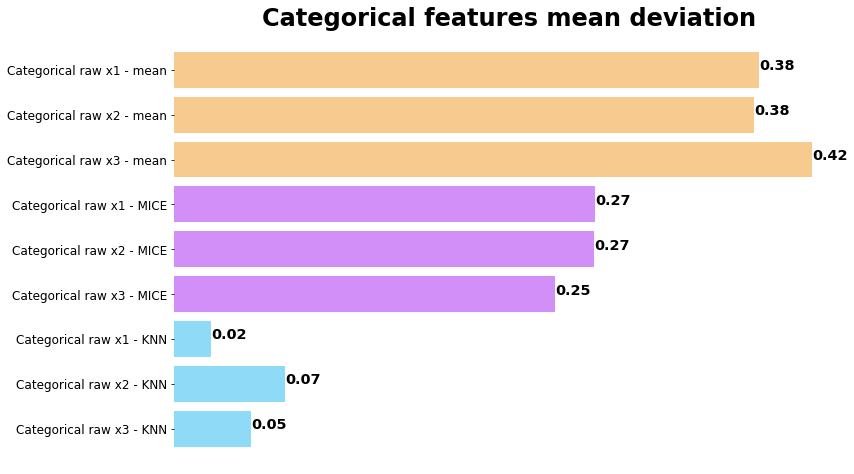

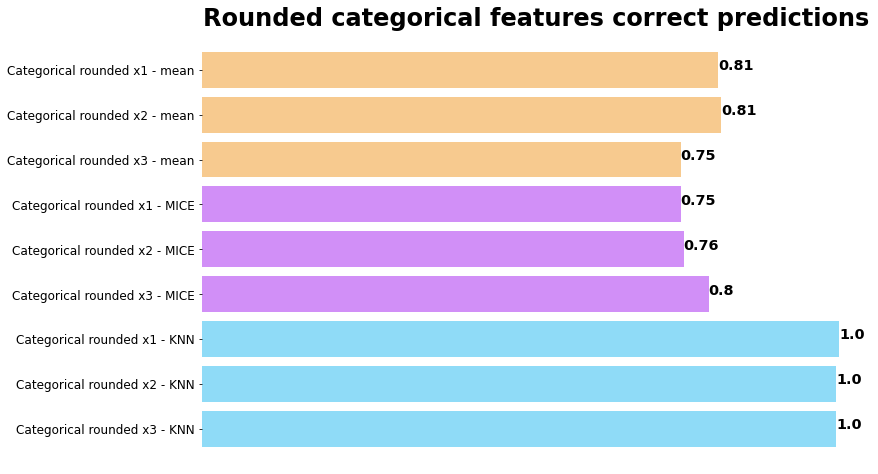

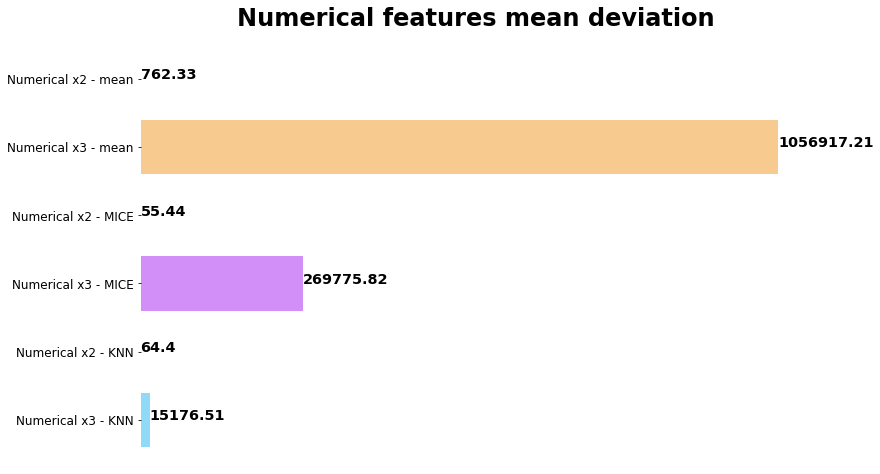

In [3]:
# Create lists to iterate over
methods = [
    "mean",
    "MICE",
    "KNN"
]

features = [
    "Categorical raw",
    "Categorical rounded",
    "Numerical"
]

titles = [
    "Categorical features mean deviation",
    "Rounded categorical features correct predictions",
    "Numerical features mean deviation"
]

dict_keys = [
    "Cat_raw_x",
    "Cat_round_x",
    "Num_x"
]

values_indexes = [
    [range(0,3), range(3,6), range(6,9)],
    [range(0,3), range(3,6), range(6,9)],
    [range(0,2), range(2,4), range(4,6)]
]

colors = [
    "#f7ca8f",
    "#d18ff7",
    "#8fdbf7"
]

# Iterate over both nulls percentages
for nulls_perc in ["20", "80"]:
    
    print("\n\nResults from dataset with " + nulls_perc + "% null values:" + "\n-----------------------------------------------" )

    for feature, title, dict_key, values_index in zip(features, titles, dict_keys, values_indexes):
            
        # Initiate the plot
        fig, ax = plt.subplots(figsize=(12, 8))
        
        # Title
        plt.title(title, fontsize=24, fontweight="bold")

        # Remove all the four spines and x-axis
        for location in ['top', 'bottom', 'left', 'right']:
            ax.spines[location].set_visible(False)
        plt.xticks([])    

        # Modify labels
        ax.tick_params(axis='x', labelsize=12)
        ax.tick_params(axis='y', labelsize=12)

        # Invert location of y-axis
        plt.gca().invert_yaxis()
        
        # Iterate over the different imputation methods
        for method, color, vals_range in zip(methods, colors, values_index):
            
            if feature != "Numerical":
                labels = [feature + " x" + str(i+1) + " - " + method for i in values_index[0]]
            
            else:
                labels = [feature + " x" + str(i+2) + " - " + method for i in values_index[0]]
    
            # Choose proper dictionary keys to plot
            if feature == "Categorical raw":
                
                values = [
                    accuracy["Cat_raw_x1_" + method + "_" + nulls_perc],
                    accuracy["Cat_raw_x2_" + method + "_" + nulls_perc],
                    accuracy["Cat_raw_x3_" + method + "_" + nulls_perc]
                ]
                                
            elif feature == "Categorical rounded":
                
                values = [
                    accuracy["Cat_round_x1_" + method + "_" + nulls_perc],
                    accuracy["Cat_round_x2_" + method + "_" + nulls_perc],
                    accuracy["Cat_round_x3_" + method + "_" + nulls_perc]
                ]
                                
            elif feature == "Numerical":
                
                values = [
                    accuracy["Num_x2_" + method + "_" + nulls_perc],
                    accuracy["Num_x3_" + method + "_" + nulls_perc]
                ]
                
            # Add data to the plot
            ax.barh(y=labels, width=values, color=color)
            
            # Include values
            for index, value in zip(vals_range, values):
                plt.text(value, index, str(round(value,2)), fontsize="x-large", fontweight="bold")

        # Plot the results
        plt.show()

The analysis above shows:

1. When dealing with raw imputed categorical features and 20% null values, mean imputation was the worst performing method, specially when dealing with the categorical variable x3, which has a more complex relationship with the other features. <ins>KNN stands out as the best imputer</ins>.
2. When dealing with rounded imputed categorical features and 20% null values, MICE imputation was the worst performing method. <ins>KNN stands out as the best imputer</ins>.
3. When dealing with numerical imputed features and 20% null values, mean imputation was the worst performing method, specially when dealing with the numerical variable x3, which has a more complex relationship with the other features. MICE and KNN imputers performed similarly with numerical variable x2, however KNN performed far better with numerical variable x3. <ins>KNN stands out as the best imputer</ins>.
4. When dealing with raw imputed categorical features and 80% null values, mean imputation was the worst performing method, specially when dealing with the categorical variable x3, which has a more complex relationship with the other features. <ins>KNN stands out as the best imputer</ins>.
5. When dealing with rounded imputed categorical features and 80% null values, mean and MICE imputation performed similarly. <ins>KNN stands out as the best imputer</ins>.
6. When dealing with numerical imputed features and 80% null values, mean imputation was the worst performing method, specially when dealing with the numerical variable x3, which has a more complex relationship with the other features. MICE and KNN imputers performed similarly with numerical variable x2, however KNN performed far better with numerical variable x3. <ins>KNN stands out as the best imputer</ins>.

We'll proceed now to test how these differences affect accuracy of Linear Regression models.

## 3. Model predictions results <a class="anchor" id="bullet-3"></a>

#### Create additional strategy: drop null values

In [4]:
# Create dataframes with dropped null values
imputed_dfs["drop20"] = df_del20.dropna(axis=0)
imputed_dfs["drop80"] = df_del80.dropna(axis=0)

# Select data from target variable y with dropped null values
drop20_y = y_del20.dropna(axis=0)
drop80_y = y_del80.dropna(axis=0)

#### Create the Linear Regression models and test accuracies

In [5]:
# Create lists with dataframes and names to iterate over
df_keys = list(imputed_dfs)
df_names = ["Mean 20% nulls", "Mean 80% nulls", "MICE 20% nulls", "MICE 80% nulls", "KNN 20% nulls", "KNN 80% nulls",
           "Drop 20% nulls", "Drop 80% nulls"]

# Initiate dictionary to store RMSE values
models_rmse = {}

# Iterate over dataframes to calculate RMSE values of Linear Regression models
for df_key, df_name in zip(df_keys, df_names):
    
    # Select proper dataframe
    df = imputed_dfs[df_key]
    
    # Initiate Linear Regression model
    lr = LinearRegression()
    
    # If the strategy was to drop null values, we need a y-values dataset that has the same number of rows
    if df_name in ("Drop 20% nulls", "Drop 80% nulls"):
        if df_name == "Drop 20% nulls":
            lr.fit(df[df.index < 900], drop20_y[drop20_y.index < 900])
        elif df_name == "Drop 80% nulls":
            lr.fit(df[df.index < 900], drop80_y[drop80_y.index < 900])
        
        # Make predictions using the original values, as otherwise we would have null values on our test data
        predictions = lr.predict(df_com[df_com.index >= 900])
    
    # If the strategy followed any imputation method, we'll simply continue fitting the model on the first 90% of the dataset
    else:
        lr.fit(df[df.index < 900], y_com[y_com.index < 900])
    
        # Make predictions on the remaining 10% of the dataset
        predictions = lr.predict(df[df.index >= 900])
    
    # Use the correct y values to calculate RMSE values and add it to dictionary
    y_test = y_com[y_com.index >= 900]
    rmse = np.sqrt(mean_squared_error(predictions, y_test))
    models_rmse[df_name] = rmse

#### Plot the results

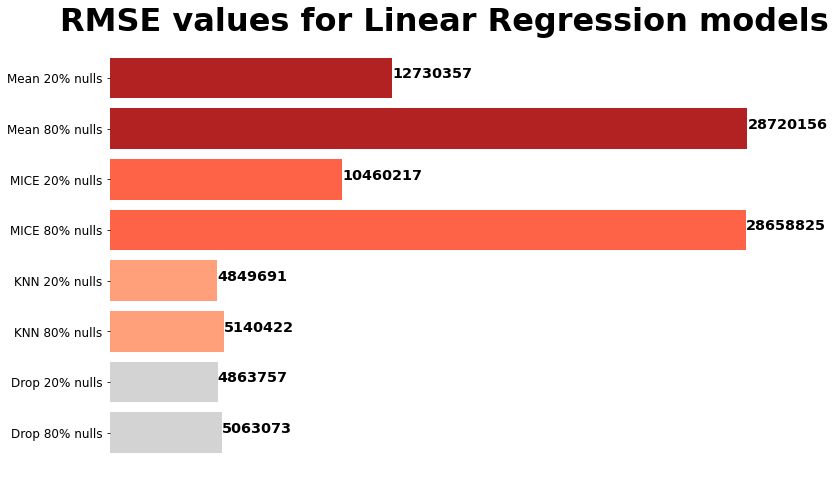

In [6]:
rmse_values = list(models_rmse.values())

# Initiate the plot
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(y=df_names, width=rmse_values, color= ["firebrick", "firebrick", "tomato", "tomato",
                                                     "lightsalmon", "lightsalmon", "lightgray", "lightgray"])

# Title
plt.title("RMSE values for Linear Regression models", fontsize=32, fontweight="bold")

# Remove all the four spines and x-axis
for location in ['top', 'bottom', 'left', 'right']:
    ax.spines[location].set_visible(False)
plt.xticks([])    

# Modify labels
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Include values
for index, value in zip(range(0,8), rmse_values):
    plt.text(value, index, str(int(value)), fontsize="x-large", fontweight="bold")

# Invert location of y-axis
plt.gca().invert_yaxis()

# Plot the results
plt.show()

The analysis above shows that mean imputation was the worst performing method when 20% null values were in place, while both mean and MICE imputation methods yielded similar results when dealing with 80% null values.

KNN imputer performed similarly than dropping null values, having the best scores. This is really important, because it means that we can achieve excellent results with KNN imputer, while not dropping any row at all. <ins>KNN stands out as the best imputer</ins>.

## 4. Conclusions <a class="anchor" id="bullet-4"></a>

Two general assertions can be drawn from the present project:

1. When comparing the accuracy of the imputed values in x features, KNN achieved the best results consistently.

2. When using the imputed values to predict target feature y, KNN got similar results than dropping null values. However, dropping null values makes it impossible to predict on future data if it comes with null values (that's why we have trained the model on the datasets with dropped rows, but predicted on the original dataset with all the data).

Therefore, we can conclude that <ins>KNN Imputer stands as the best option to deal with null values</ins>.